<a href="https://colab.research.google.com/github/Meshal-Css/Aramco-Challenge/blob/main/PV_model_data.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

library basic

In [51]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import requests
from datetime import datetime, timedelta
import json
import plotly.express as px
from ipywidgets import interact
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import precision_recall_curve, roc_auc_score, classification_report, confusion_matrix
from sklearn.inspection import permutation_importance
import folium
from folium.features import DivIcon

dataframe

In [2]:
lat, lon = 24.9584, 46.6989


PARAMS = [
    "ALLSKY_SFC_SW_DWN","CLRSKY_SFC_SW_DWN","CLOUD_AMT",
    "WS10M","WD10M","PRECTOTCORR","TS","ALLSKY_SFC_LW_DWN",
    "ALLSKY_SFC_UV_INDEX","RH2M","GWETTOP"
]


end_date = datetime.now()
start_date = end_date - timedelta(days=365*3 + 5)

def fetch_power_daily(lat, lon, start_dt, end_dt, params):
    start = start_dt.strftime("%Y%m%d")
    end   = end_dt.strftime("%Y%m%d")
    url = (
        "https://power.larc.nasa.gov/api/temporal/daily/point"
        f"?parameters={','.join(params)}"
        f"&latitude={lat}&longitude={lon}"
        f"&start={start}&end={end}&community=AG&format=JSON"
    )
    r = requests.get(url, timeout=60)
    r.raise_for_status()
    data = r.json()["properties"]["parameter"]
    df = pd.DataFrame({k: pd.Series(v) for k, v in data.items()})
    df.index = pd.to_datetime(df.index, format="%Y%m%d")
    df.index.name = "Date"
    return df


df3y = fetch_power_daily(lat, lon, start_date, end_date, PARAMS)


for c in df3y.columns:
    df3y[c] = pd.to_numeric(df3y[c], errors="coerce")


df3y.to_csv("nasa_data_3y.csv")
print("✅ جاهز: nasa_data_3y.csv | shape:", df3y.shape)
print(df3y.tail(3))


✅ جاهز: nasa_data_3y.csv | shape: (1101, 11)
            ALLSKY_SFC_SW_DWN  CLRSKY_SFC_SW_DWN  CLOUD_AMT  WS10M  WD10M  \
Date                                                                        
2025-08-23             -999.0             -999.0     -999.0 -999.0 -999.0   
2025-08-24             -999.0             -999.0     -999.0 -999.0 -999.0   
2025-08-25             -999.0             -999.0     -999.0 -999.0 -999.0   

            PRECTOTCORR     TS  ALLSKY_SFC_LW_DWN  ALLSKY_SFC_UV_INDEX   RH2M  \
Date                                                                            
2025-08-23       -999.0 -999.0             -999.0               -999.0 -999.0   
2025-08-24       -999.0 -999.0             -999.0               -999.0 -999.0   
2025-08-25       -999.0 -999.0             -999.0               -999.0 -999.0   

            GWETTOP  
Date                 
2025-08-23   -999.0  
2025-08-24   -999.0  
2025-08-25   -999.0  


In [3]:
df = pd.read_csv("/content/nasa_data_3y.csv")
df.sample(30)

,Date,ALLSKY_SFC_SW_DWN,CLRSKY_SFC_SW_DWN,CLOUD_AMT,WS10M,WD10M,PRECTOTCORR,TS,ALLSKY_SFC_LW_DWN,ALLSKY_SFC_UV_INDEX,RH2M,GWETTOP
911,2025-02-17,17.47,19.22,37.14,3.55,32.4,0.42,19.01,30.41,1.29,74.34,0.37
787,2024-10-16,20.69,20.76,5.57,3.90,95.9,0.00,29.04,30.42,1.56,21.01,0.05
118,2022-12-17,14.50,14.84,7.47,3.46,24.0,0.00,16.41,27.35,0.88,70.06,0.33
874,2025-01-11,12.56,15.52,43.91,4.11,169.6,0.00,12.51,28.15,0.89,45.70,0.31
889,2025-01-26,7.42,16.01,65.43,2.62,46.7,0.93,13.55,29.61,0.53,61.83,0.27
683,2024-07-04,28.63,28.68,2.82,5.51,348.6,0.00,36.78,33.06,2.68,13.19,0.08
691,2024-07-12,26.73,26.99,16.21,4.49,356.4,0.00,40.81,36.38,2.44,12.78,0.07
577,2024-03-20,20.14,21.88,21.77,4.87,22.3,0.00,21.87,30.99,1.81,57.78,0.35
202,2023-03-11,21.15,21.47,29.12,4.56,51.6,0.18,20.47,30.05,1.82,50.26,0.32
426,2023-10-21,19.55,19.66,5.51,3.69,177.1,0.00,28.63,30.49,1.51,21.53,0.05


EDA

In [4]:
df.index = pd.to_datetime(df["Date"])
df = df.drop(columns=["Date"]).sort_index()

In [5]:
print("Shape:", df.shape)
print("Date range:", df.index.min().date(), "→", df.index.max().date())
display(df.head())

Shape: (1101, 11)
Date range: 2022-08-21 → 2025-08-25


,ALLSKY_SFC_SW_DWN,CLRSKY_SFC_SW_DWN,CLOUD_AMT,WS10M,WD10M,PRECTOTCORR,TS,ALLSKY_SFC_LW_DWN,ALLSKY_SFC_UV_INDEX,RH2M,GWETTOP
Date,,,,,,,,,,,
2022-08-21,23.89,25.81,41.82,3.95,25.0,0.0,38.08,35.64,2.31,11.99,0.06
2022-08-22,24.33,25.37,25.62,2.92,6.2,0.0,38.19,34.84,2.16,14.97,0.06
2022-08-23,24.75,25.35,20.24,3.71,54.2,0.0,37.14,34.87,2.27,15.84,0.06
2022-08-24,25.33,25.57,22.82,3.24,55.6,0.0,36.89,34.58,2.33,16.59,0.06
2022-08-25,20.48,24.95,59.55,2.84,35.8,0.0,36.55,35.50,1.87,14.79,0.06


In [6]:
print("\nDtypes:\n", df.dtypes)
print("\nMissing per column:\n", df.isna().sum())


Dtypes:
 ALLSKY_SFC_SW_DWN      float64
CLRSKY_SFC_SW_DWN      float64
CLOUD_AMT              float64
WS10M                  float64
WD10M                  float64
PRECTOTCORR            float64
TS                     float64
ALLSKY_SFC_LW_DWN      float64
ALLSKY_SFC_UV_INDEX    float64
RH2M                   float64
GWETTOP                float64
dtype: object

Missing per column:
 ALLSKY_SFC_SW_DWN      0
CLRSKY_SFC_SW_DWN      0
CLOUD_AMT              0
WS10M                  0
WD10M                  0
PRECTOTCORR            0
TS                     0
ALLSKY_SFC_LW_DWN      0
ALLSKY_SFC_UV_INDEX    0
RH2M                   0
GWETTOP                0
dtype: int64


cheack duplicated

In [7]:
dups = df.index.duplicated().sum()
print(f"\nDuplicate dates: {dups}")


Duplicate dates: 0


In [8]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1101 entries, 2022-08-21 to 2025-08-25
Data columns (total 11 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   ALLSKY_SFC_SW_DWN    1101 non-null   float64
 1   CLRSKY_SFC_SW_DWN    1101 non-null   float64
 2   CLOUD_AMT            1101 non-null   float64
 3   WS10M                1101 non-null   float64
 4   WD10M                1101 non-null   float64
 5   PRECTOTCORR          1101 non-null   float64
 6   TS                   1101 non-null   float64
 7   ALLSKY_SFC_LW_DWN    1101 non-null   float64
 8   ALLSKY_SFC_UV_INDEX  1101 non-null   float64
 9   RH2M                 1101 non-null   float64
 10  GWETTOP              1101 non-null   float64
dtypes: float64(11)
memory usage: 103.2 KB


Explore whether there are missing days or not ?

In [9]:
full_idx = pd.date_range(df.index.min(), df.index.max(), freq="D")
missing_days = full_idx.difference(df.index)
print("Missing days count:", len(missing_days))

Missing days count: 0


Engineering analysis

In [10]:
rules = {
    "CLOUD_AMT": (0, 100),
    "RH2M": (0, 100),
    "WS10M": (0, None),
    "WD10M": (0, 360),
    "ALLSKY_SFC_SW_DWN": (0, None),
    "CLRSKY_SFC_SW_DWN": (0, None),
    "ALLSKY_SFC_UV_INDEX": (0, None),
    "ALLSKY_SFC_LW_DWN": (0, None),
    "PRECTOTCORR": (0, None),
    "GWETTOP": (0, None),
    "TS": (None, None)
}
bad_counts = {}
for col,(lo,hi) in rules.items():
    if col in df.columns:
        bad = pd.Series(False, index=df.index)
        if lo is not None: bad |= (df[col] < lo)
        if hi is not None: bad |= (df[col] > hi)
        bad_counts[col] = int(bad.sum())
bad_counts

{'CLOUD_AMT': 87,
 'RH2M': 3,
 'WS10M': 3,
 'WD10M': 3,
 'ALLSKY_SFC_SW_DWN': 5,
 'CLRSKY_SFC_SW_DWN': 28,
 'ALLSKY_SFC_UV_INDEX': 87,
 'ALLSKY_SFC_LW_DWN': 5,
 'PRECTOTCORR': 3,
 'GWETTOP': 3,
 'TS': 0}

In [11]:

df['CLOUD_AMT'] = df['CLOUD_AMT'].clip(0, 100)
df['RH2M'] = df['RH2M'].clip(0, 100)
df['ALLSKY_SFC_UV_INDEX'] = df['ALLSKY_SFC_UV_INDEX'].clip(0, 11)

# coulmns ≥ 0
cols_nonneg = [
    'WS10M','ALLSKY_SFC_SW_DWN','CLRSKY_SFC_SW_DWN',
    'ALLSKY_SFC_LW_DWN','PRECTOTCORR','GWETTOP'
]
for c in cols_nonneg:
    if c in df.columns:
        df[c] = df[c].clip(lower=0)


if 'WD10M' in df.columns:
    df['WD10M'] = df['WD10M'] % 360


df = df.replace([np.inf, -np.inf], np.nan)


df = df.interpolate(limit_direction='both')


print("Missing after clean:\n", df.isna().sum())
print("Range checks:")
for c in ['CLOUD_AMT','RH2M','ALLSKY_SFC_UV_INDEX','WD10M','WS10M','PRECTOTCORR']:
    if c in df.columns:
        print(c, "→", float(df[c].min()), "to", float(df[c].max()))

Missing after clean:
 ALLSKY_SFC_SW_DWN      0
CLRSKY_SFC_SW_DWN      0
CLOUD_AMT              0
WS10M                  0
WD10M                  0
PRECTOTCORR            0
TS                     0
ALLSKY_SFC_LW_DWN      0
ALLSKY_SFC_UV_INDEX    0
RH2M                   0
GWETTOP                0
dtype: int64
Range checks:
CLOUD_AMT → 0.0 to 99.73
RH2M → 0.0 to 87.66
ALLSKY_SFC_UV_INDEX → 0.0 to 2.86
WD10M → 0.0 to 359.9
WS10M → 0.0 to 8.74
PRECTOTCORR → 0.0 to 33.76


In [12]:
df.head(3)

,ALLSKY_SFC_SW_DWN,CLRSKY_SFC_SW_DWN,CLOUD_AMT,WS10M,WD10M,PRECTOTCORR,TS,ALLSKY_SFC_LW_DWN,ALLSKY_SFC_UV_INDEX,RH2M,GWETTOP
Date,,,,,,,,,,,
2022-08-21,23.89,25.81,41.82,3.95,25.0,0.0,38.08,35.64,2.31,11.99,0.06
2022-08-22,24.33,25.37,25.62,2.92,6.2,0.0,38.19,34.84,2.16,14.97,0.06
2022-08-23,24.75,25.35,20.24,3.71,54.2,0.0,37.14,34.87,2.27,15.84,0.06


In [13]:
df['k_t'] = (df['ALLSKY_SFC_SW_DWN'] / df['CLRSKY_SFC_SW_DWN']).replace([np.inf,-np.inf], np.nan).clip(0,1)
df['cloud_norm'] = (df['CLOUD_AMT']/100).clip(0,1)
df['Dust_Index'] = (1 - df['k_t']) * (1 - df['cloud_norm'])
is_rain = (df['PRECTOTCORR'] > 0).astype(int)
df['days_since_rain'] = (~(is_rain.astype(bool))).groupby(is_rain.cumsum()).cumcount()
# ===============
df['u10'] = df['WS10M'] * np.cos(np.deg2rad(df['WD10M']))
df['v10'] = df['WS10M'] * np.sin(np.deg2rad(df['WD10M']))
#================
for col in ['ALLSKY_SFC_SW_DWN','CLRSKY_SFC_SW_DWN','WS10M','RH2M','CLOUD_AMT','Dust_Index']:
    df[f'{col}_r7'] = df[col].rolling(7, min_periods=3).mean()
#================
thr = df['Dust_Index'].quantile(0.75)
df['High_Dust_Risk'] = (df['Dust_Index'] > thr).astype(int)

print("عتبة الخطر:", round(thr,3))
print("نسبة الأيام عالية الخطر:", f"{df['High_Dust_Risk'].mean():.1%}")

عتبة الخطر: 0.031
نسبة الأيام عالية الخطر: 24.3%


/tmp/ipython-input-3947458283.py:5: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot([di0, di1], labels=['Low Risk','High Risk'], showfliers=False)


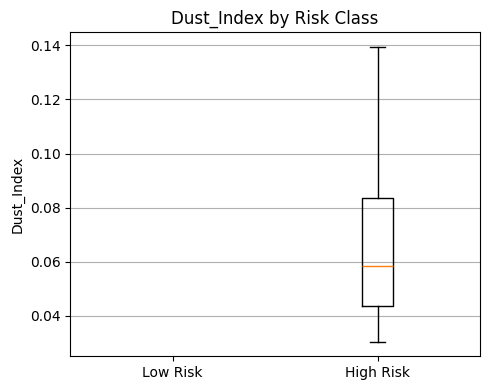

High-risk share: 24.34%


In [14]:
di0 = df.loc[df['High_Dust_Risk']==0, 'Dust_Index']
di1 = df.loc[df['High_Dust_Risk']==1, 'Dust_Index']

plt.figure(figsize=(5,4))
plt.boxplot([di0, di1], labels=['Low Risk','High Risk'], showfliers=False)
plt.title('Dust_Index by Risk Class')
plt.ylabel('Dust_Index')
plt.grid(True, axis='y')
plt.tight_layout()
plt.show()

print(f"High-risk share: {df['High_Dust_Risk'].mean():.2%}")

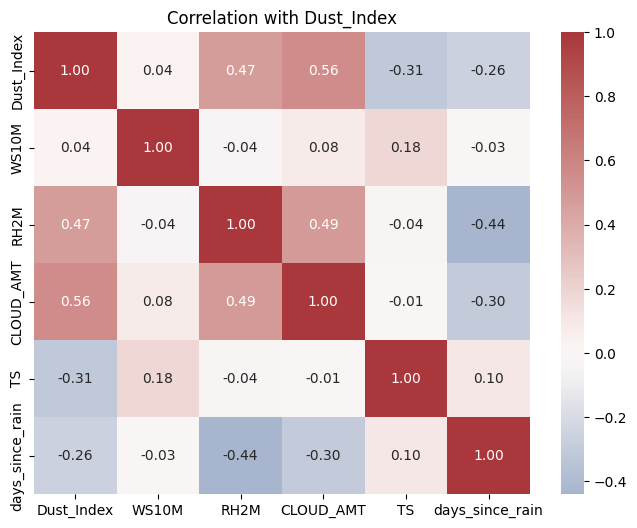

In [15]:
corr = df[['Dust_Index','WS10M','RH2M','CLOUD_AMT','TS','days_since_rain']].corr()

plt.figure(figsize=(8,6))
sns.heatmap(corr, annot=True, cmap='vlag', center=0, fmt=".2f")
plt.title("Correlation with Dust_Index")
plt.show()

/tmp/ipython-input-2234907943.py:1: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  monthly = df.resample('M').mean(numeric_only=True)


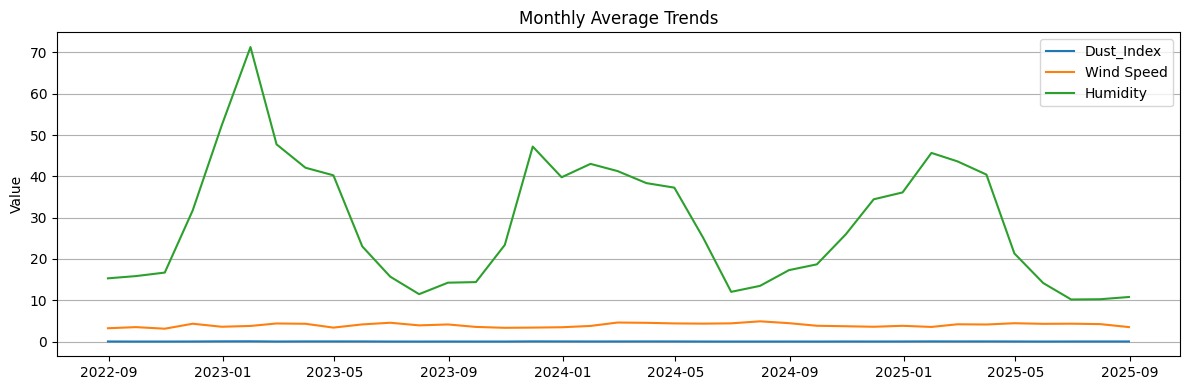

In [16]:
monthly = df.resample('M').mean(numeric_only=True)
#=========
plt.figure(figsize=(12,4))
plt.plot(monthly.index, monthly['Dust_Index'], label='Dust_Index')
plt.plot(monthly.index, monthly['WS10M'], label='Wind Speed')
plt.plot(monthly.index, monthly['RH2M'], label='Humidity')
plt.title("Monthly Average Trends")
plt.ylabel("Value")
plt.legend()
plt.grid(True, axis='y')
plt.tight_layout()
plt.show()

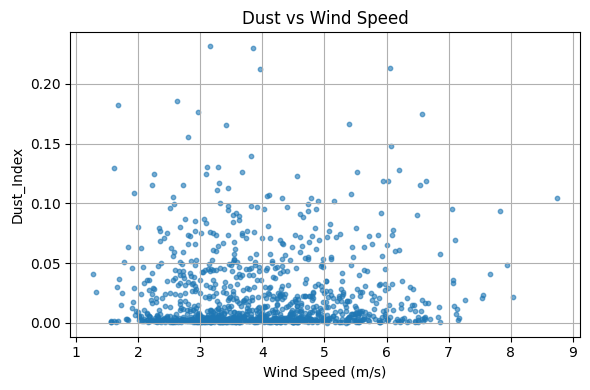

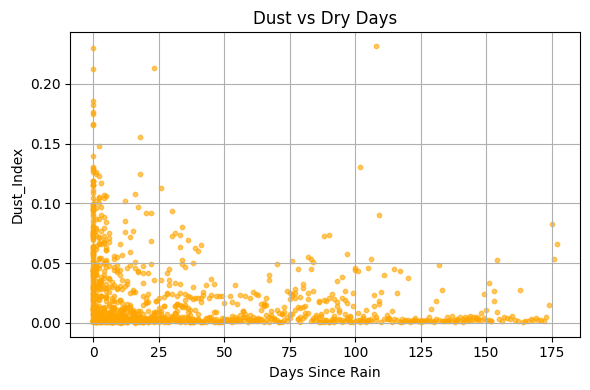

In [17]:
plt.figure(figsize=(6,4))
plt.scatter(df['WS10M'], df['Dust_Index'], s=10, alpha=0.6)
plt.xlabel('Wind Speed (m/s)')
plt.ylabel('Dust_Index')
plt.title('Dust vs Wind Speed')
plt.grid(True)
plt.tight_layout()
plt.show()
#===========
plt.figure(figsize=(6,4))
plt.scatter(df['days_since_rain'], df['Dust_Index'], s=10, alpha=0.6, c='orange')
plt.xlabel('Days Since Rain')
plt.ylabel('Dust_Index')
plt.title('Dust vs Dry Days')
plt.grid(True)
plt.tight_layout()
plt.show()

/tmp/ipython-input-228006264.py:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='month', y='Dust_Index', data=df, showfliers=False, palette="Set2")


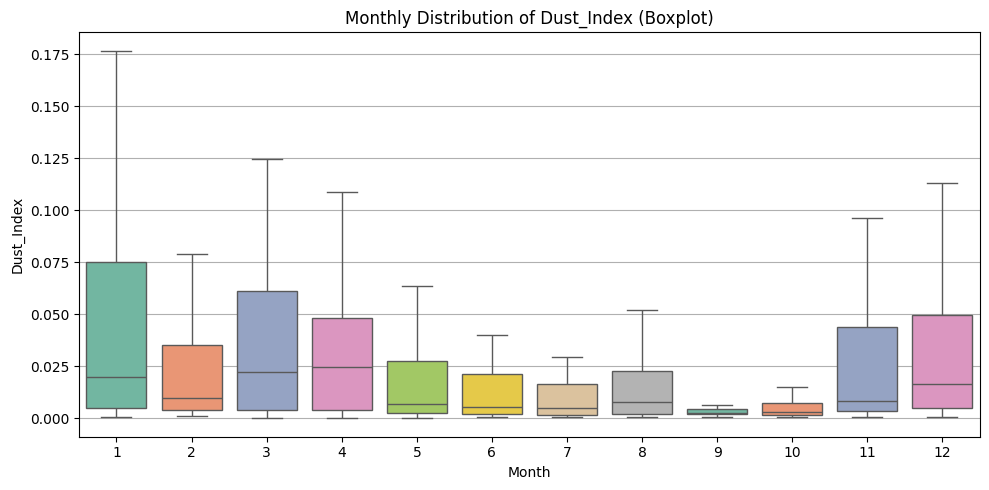

In [18]:
df['month'] = df.index.month
# =======
plt.figure(figsize=(10,5))
sns.boxplot(x='month', y='Dust_Index', data=df, showfliers=False, palette="Set2")
plt.title('Monthly Distribution of Dust_Index (Boxplot)')
plt.xlabel('Month')
plt.ylabel('Dust_Index')
plt.grid(True, axis='y')
plt.tight_layout()
plt.show()

EDA

In [19]:
metadata = {
    "dataset_info": {
        "name": "nasa_ksia_weather_data",
        "time_range": "2023 (366 يومًا)",
        "location": {
            "name": "King Khalid International Airport",
            "coordinates": {"latitude": 24.9584, "longitude": 46.6989}
        },
        "data_quality": {
            "complete": True,
            "missing_values": 0
        }
    },
    "columns": [
        {
            "name": "Date",
            "type": "object",
            "description": "تاريخ القياس (يفضل تحويله إلى DateTime)",
            "unit": "YYYY-MM-DD"
        },
        {
            "name": "WD10M",
            "type": "float64",
            "description": "اتجاه الرياح عند 10 أمتار",
            "unit": "درجة (0-360)"
        },
        {
            "name": "RH2M",
            "type": "float64",
            "description": "الرطوبة النسبية عند 2 متر",
            "unit": "%"
        },
        {
            "name": "WS10M",
            "type": "float64",
            "description": "سرعة الرياح عند 10 أمتار",
            "unit": "m/s"
        },
        {
            "name": "ALLSKY_SFC_SW_DWN",
            "type": "float64",
            "description": "الإشعاع الشمسي الكلي على السطح",
            "unit": "W/m²"
        },
        {
            "name": "CLOUD_AMT",
            "type": "float64",
            "description": "نسبة الغطاء السحابي",
            "unit": "% (0-100)"
        },
        {
            "name": "CLRSKY_SFC_SW_DWN",
            "type": "float64",
            "description": "الإشعاع الشمسي في السماء الصافية",
            "unit": "W/m²"
        },
        {
            "name": "ALLSKY_SFC_UV_INDEX",
            "type": "float64",
            "description": "مؤشر الأشعة فوق البنفسجية",
            "unit": "0-11+"
        },
        {
            "name": "TS",
            "type": "float64",
            "description": "درجة حرارة سطح الأرض",
            "unit": "°C"
        },
        {
            "name": "ALLSKY_SFC_LW_DWN",
            "type": "float64",
            "description": "الإشعاع الحراري الطويل الساقط",
            "unit": "W/m²"
        },
        {
            "name": "GWETTOP",
            "type": "float64",
            "description": "رطوبة التربة السطحية (0-5 سم)",
            "unit": "% (0-100)"
        },
        {
            "name": "PRECTOTCORR",
            "type": "float64",
            "description": "هطول الأمطار اليومي المصحح",
            "unit": "mm/day"
        }
    ],
    "notes": "يحتوي هذا الملف على بيانات يومية لمدة عام واحد (366 يومًا) بدون قيم مفقودة."
}


with open('nasa_metadata.json', 'w', encoding='utf-8') as f:
    json.dump(metadata, f, ensure_ascii=False, indent=4)

print("تم الحفظ'nasa_metadata.json'")

تم الحفظ'nasa_metadata.json'


In [20]:
d = df[['WD10M','WS10M','High_Dust_Risk']].dropna().copy()
d = d[(d['WD10M']>=0) & (d['WD10M']<=360) & (d['WS10M']>=0)]
assert len(d)>0, "لا توجد صفوف صالحة بعد التنظيف."

In [21]:
n_sectors = 16
edges = np.linspace(0, 360, n_sectors+1)
centers = (edges[:-1] + edges[1:]) / 2
theta = np.deg2rad(centers)
width = np.deg2rad(360/n_sectors)

wd = (d['WD10M'].values % 360)
risk = d['High_Dust_Risk'].astype(int).values


counts, _ = np.histogram(wd, bins=edges)
freq = counts / max(counts.sum(), 1)


counts_r, _ = np.histogram(wd[risk==1], bins=edges)
freq_r = counts_r / max(counts_r.sum(), 1)

risk_rate = np.divide(counts_r, counts, out=np.zeros_like(counts_r, dtype=float), where=counts>0)

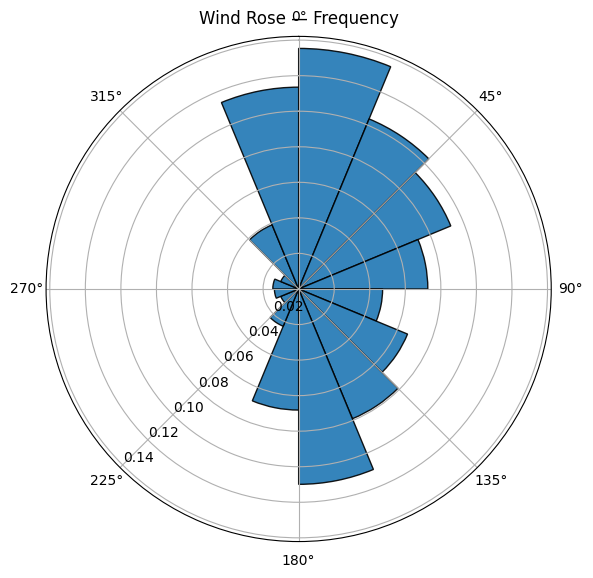

In [22]:
fig = plt.figure(figsize=(6,6))
ax = fig.add_subplot(111, projection='polar')
ax.set_theta_zero_location('N'); ax.set_theta_direction(-1)
ax.bar(theta, freq, width=width, edgecolor='k', alpha=0.9)
ax.set_title('Wind Rose — Frequency', va='bottom'); ax.set_rlabel_position(225)
plt.tight_layout(); plt.show()

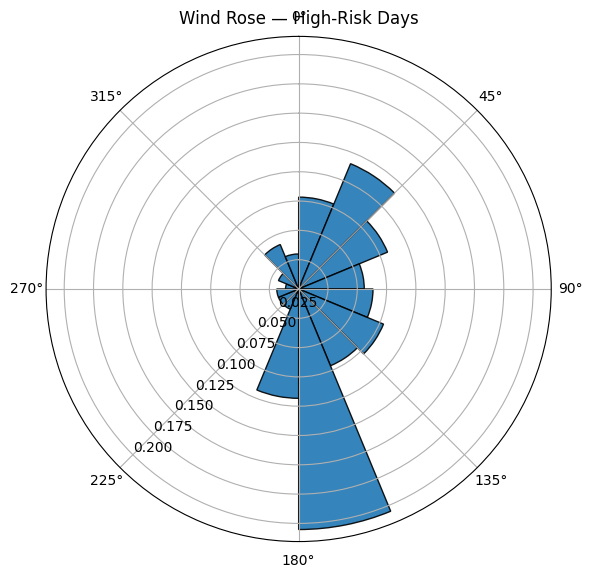

In [23]:
fig = plt.figure(figsize=(6,6))
ax = fig.add_subplot(111, projection='polar')
ax.set_theta_zero_location('N'); ax.set_theta_direction(-1)
ax.bar(theta, freq_r, width=width, edgecolor='k', alpha=0.9)
ax.set_title('Wind Rose — High-Risk Days', va='bottom'); ax.set_rlabel_position(225)
plt.tight_layout(); plt.show()

/tmp/ipython-input-905424617.py:6: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = plt.cm.get_cmap('Reds')


ValueError: Unable to determine Axes to steal space for Colorbar. Either provide the *cax* argument to use as the Axes for the Colorbar, provide the *ax* argument to steal space from it, or add *mappable* to an Axes.

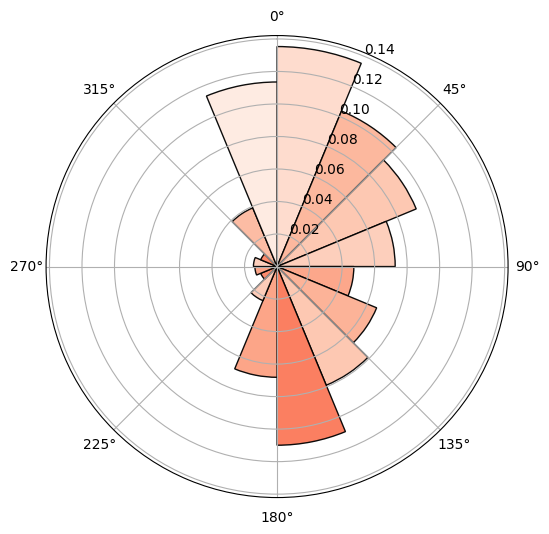

In [24]:
fig = plt.figure(figsize=(6,6))
ax = fig.add_subplot(111, projection='polar')
ax.set_theta_zero_location('N'); ax.set_theta_direction(-1)
bars = ax.bar(theta, freq, width=width, edgecolor='k')

cmap = plt.cm.get_cmap('Reds')
colors = cmap(np.clip(risk_rate, 0, 1))
for b, c in zip(bars, colors):
    b.set_facecolor(c); b.set_alpha(0.95)

sm = plt.cm.ScalarMappable(cmap=cmap, norm=plt.Normalize(0,1))
sm.set_array([])
cbar = plt.colorbar(sm, pad=0.1); cbar.set_label('High-Risk Share')
ax.set_title('Wind Rose — Frequency (height) & Risk Share (color)', va='bottom')
ax.set_rlabel_position(225)
plt.tight_layout(); plt.show()


summary

In [25]:
top_freq_idx = np.argsort(freq)[-2:][::-1]
top_risk_idx = np.argsort(risk_rate)[-2:][::-1]
def sec_label(i): return f"{int(edges[i])}°–{int(edges[i+1])}°"
summary = {
    "top_frequency_sectors": [sec_label(i) for i in top_freq_idx],
    "top_frequency_%": [round(100*freq[i],1) for i in top_freq_idx],
    "top_risk_share_sectors": [sec_label(i) for i in top_risk_idx],
    "top_risk_share_%": [round(100*risk_rate[i],1) for i in top_risk_idx],
}
print(summary)

{'top_frequency_sectors': ['0°–22°', '337°–360°'], 'top_frequency_%': [np.float64(13.5), np.float64(11.4)], 'top_risk_share_sectors': ['157°–180°', '292°–315°'], 'top_risk_share_%': [np.float64(45.5), np.float64(41.7)]}


MAP

In [26]:
N = 16
edges = np.linspace(0, 360, N+1)
centers = (edges[:-1] + edges[1:]) / 2


wd = (d['WD10M'].values % 360)
risk = d['High_Dust_Risk'].astype(int).values

counts, _   = np.histogram(wd, bins=edges)
counts_r, _ = np.histogram(wd[risk==1], bins=edges)

freq = counts / max(counts.sum(), 1)
risk_share = np.divide(counts_r, counts, out=np.zeros_like(counts_r, dtype=float), where=counts>0)  # 0..1


lat, lon = 24.9584, 46.6989  # KSIA
m = folium.Map(location=[lat, lon], zoom_start=9, tiles="CartoDB positron")


max_km = 35.0
max_freq = freq.max() if freq.max()>0 else 1.0

def dest_point(lat0, lon0, bearing_deg, distance_km):
    """حاسب نقطة النهاية من نقطة البداية + زاوية + مسافة (تقريب بسيط)."""
    R = 6371.0
    br = np.deg2rad(bearing_deg)
    lat0r, lon0r = np.deg2rad(lat0), np.deg2rad(lon0)
    lat1 = np.arcsin(np.sin(lat0r)*np.cos(distance_km/R) +
                     np.cos(lat0r)*np.sin(distance_km/R)*np.cos(br))
    lon1 = lon0r + np.arctan2(np.sin(br)*np.sin(distance_km/R)*np.cos(lat0r),
                              np.cos(distance_km/R)-np.sin(lat0r)*np.sin(lat1))
    return np.rad2deg(lat1), np.rad2deg(lon1)


for i, cen in enumerate(centers):
    if freq[i] == 0:
        continue

    L = (freq[i] / max_freq) * max_km


    r = int( (0xb3 - 0xfe) * risk_share[i] + 0xfe )
    g = int( (0x00 - 0xe5) * risk_share[i] + 0xe5 )
    b = int( (0x00 - 0xe5) * risk_share[i] + 0xe5 )
    color = f'#{r:02x}{g:02x}{b:02x}'


    lat1, lon1 = dest_point(lat, lon, cen, L)

    text = (f"<b>{int(edges[i])}°–{int(edges[i+1])}°</b><br>"
            f"Freq: {freq[i]*100:.1f}%<br>"
            f"Risk share: {risk_share[i]*100:.1f}%")

    folium.PolyLine(locations=[(lat, lon), (lat1, lon1)],
                    tooltip=text, color=color, weight=5, opacity=0.9).add_to(m)


folium.CircleMarker(location=[lat, lon], radius=6, color="#1f77b4",
                    fill=True, fill_opacity=1.0,
                    tooltip="King Khalid International Airport (KKIA)").add_to(m)

folium.map.Marker(
    [lat, lon],
    icon=DivIcon(icon_size=(150,36), icon_anchor=(0,0),
                 html='<div style="font-size: 12px; color:#222;"><b>KKIA</b></div>')
).add_to(m)

#======= explin at website ==========
legend_html = """
<div style="
 position: fixed; bottom: 20px; left: 20px; z-index: 9999;
 background: white; padding: 10px 12px; border: 1px solid #ccc; border-radius: 6px;">
<b>Legend</b><br>
Line length = Wind direction frequency<br>
Line color = High-risk share<br>
<span style="display:inline-block;width:14px;height:10px;background:#fee5e5;border:1px solid #ccc;"></span> Low risk
&nbsp;&nbsp;
<span style="display:inline-block;width:14px;height:10px;background:#b30000;border:1px solid #ccc;"></span> High risk
</div>
"""
m.get_root().html.add_child(folium.Element(legend_html))

m.save("kkia_wind_sources.html")

In [27]:
! pip install cdsapi xarray netCDF4

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.3/9.3 MB 19.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.4/1.4 MB 23.5 MB/s eta 0:00:00


anlysis for nasa data

In [28]:
df.columns

Index(['ALLSKY_SFC_SW_DWN', 'CLRSKY_SFC_SW_DWN', 'CLOUD_AMT', 'WS10M', 'WD10M',
       'PRECTOTCORR', 'TS', 'ALLSKY_SFC_LW_DWN', 'ALLSKY_SFC_UV_INDEX', 'RH2M',
       'GWETTOP', 'k_t', 'cloud_norm', 'Dust_Index', 'days_since_rain', 'u10',
       'v10', 'ALLSKY_SFC_SW_DWN_r7', 'CLRSKY_SFC_SW_DWN_r7', 'WS10M_r7',
       'RH2M_r7', 'CLOUD_AMT_r7', 'Dust_Index_r7', 'High_Dust_Risk', 'month'],
      dtype='object')

In [29]:
df

,ALLSKY_SFC_SW_DWN,CLRSKY_SFC_SW_DWN,CLOUD_AMT,WS10M,WD10M,PRECTOTCORR,TS,ALLSKY_SFC_LW_DWN,ALLSKY_SFC_UV_INDEX,RH2M,...,u10,v10,ALLSKY_SFC_SW_DWN_r7,CLRSKY_SFC_SW_DWN_r7,WS10M_r7,RH2M_r7,CLOUD_AMT_r7,Dust_Index_r7,High_Dust_Risk,month
Date,,,,,,,,,,,,,,,,,,,,,
2022-08-21,23.89,25.81,41.82,3.95,25.0,0.0,38.08,35.64,2.31,11.99,...,3.579916,1.669342,NaN,NaN,NaN,NaN,NaN,NaN,1,8
2022-08-22,24.33,25.37,25.62,2.92,6.2,0.0,38.19,34.84,2.16,14.97,...,2.902921,0.315358,NaN,NaN,NaN,NaN,NaN,NaN,0,8
2022-08-23,24.75,25.35,20.24,3.71,54.2,0.0,37.14,34.87,2.27,15.84,...,2.170193,3.009047,24.323333,25.510000,3.526667,14.266667,29.226667,0.030883,0,8
2022-08-24,25.33,25.57,22.82,3.24,55.6,0.0,36.89,34.58,2.33,16.59,...,1.830493,2.673368,24.575000,25.525000,3.455000,14.847500,27.625000,0.024973,0,8
2022-08-25,20.48,24.95,59.55,2.84,35.8,0.0,36.55,35.50,1.87,14.79,...,2.303421,1.661280,23.756000,25.410000,3.332000,14.836000,34.010000,0.034473,1,8
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2025-08-21,0.00,0.00,0.00,4.85,33.2,0.0,36.96,0.00,0.00,12.37,...,4.058307,2.655682,21.400000,11.182857,4.858571,8.932857,0.000000,0.012988,0,8
2025-08-22,0.00,0.00,0.00,3.35,42.1,0.0,37.16,0.00,0.00,17.01,...,2.485619,2.245929,17.647143,7.368571,4.701429,10.508571,0.000000,NaN,0,8
2025-08-23,0.00,0.00,0.00,0.00,81.0,0.0,-999.00,0.00,0.00,0.00,...,0.000000,0.000000,14.025714,7.368571,4.027143,9.218571,0.000000,NaN,0,8


In [30]:
df.isna().sum()

,0
ALLSKY_SFC_SW_DWN,0
CLRSKY_SFC_SW_DWN,0
CLOUD_AMT,0
WS10M,0
WD10M,0
PRECTOTCORR,0
TS,0
ALLSKY_SFC_LW_DWN,0
ALLSKY_SFC_UV_INDEX,0
RH2M,0


Solve the NAn value

In [32]:
eps = 1e-6
kt_safe = (df['ALLSKY_SFC_SW_DWN'] / df['CLRSKY_SFC_SW_DWN'].clip(lower=eps)).clip(0,1)
kt_safe = kt_safe.mask(df['CLRSKY_SFC_SW_DWN'] < 1e-3, np.nan)
df['k_t'] = kt_safe.interpolate(limit_direction='both')

df['cloud_norm'] = (df['CLOUD_AMT']/100).clip(0,1)


df['Dust_Index'] = ((1 - df['k_t']) * (1 - df['cloud_norm'])).clip(0,1)
df['Dust_Index'] = df['Dust_Index'].interpolate(limit_direction='both')


roll_cols = ['ALLSKY_SFC_SW_DWN','CLRSKY_SFC_SW_DWN','WS10M','RH2M','CLOUD_AMT','Dust_Index']
for c in roll_cols:
    r7 = df[c].rolling(7, min_periods=1).mean()
    df[f'{c}_r7'] = r7.bfill(limit=7)


check_cols = [
    'k_t','Dust_Index','ALLSKY_SFC_SW_DWN_r7','CLRSKY_SFC_SW_DWN_r7',
    'WS10M_r7','RH2M_r7','CLOUD_AMT_r7','Dust_Index_r7'
]
print(df[check_cols].isna().sum().sort_values(ascending=False))

k_t                     0
Dust_Index              0
ALLSKY_SFC_SW_DWN_r7    0
CLRSKY_SFC_SW_DWN_r7    0
WS10M_r7                0
RH2M_r7                 0
CLOUD_AMT_r7            0
Dust_Index_r7           0
dtype: int64


In [33]:
roll_cols = ['ALLSKY_SFC_SW_DWN','CLRSKY_SFC_SW_DWN','WS10M','RH2M','CLOUD_AMT','Dust_Index']
for c in roll_cols:
    r7 = df[c].rolling(7, min_periods=1).mean()

    df[f'{c}_r7'] = r7.fillna(method='bfill', limit=7)


/tmp/ipython-input-710488210.py:5: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df[f'{c}_r7'] = r7.fillna(method='bfill', limit=7)


In [34]:
check_cols = [
    'k_t','Dust_Index','ALLSKY_SFC_SW_DWN_r7','CLRSKY_SFC_SW_DWN_r7',
    'WS10M_r7','RH2M_r7','CLOUD_AMT_r7','Dust_Index_r7'
]
print(df[check_cols].isna().sum().sort_values(ascending=False))

k_t                     0
Dust_Index              0
ALLSKY_SFC_SW_DWN_r7    0
CLRSKY_SFC_SW_DWN_r7    0
WS10M_r7                0
RH2M_r7                 0
CLOUD_AMT_r7            0
Dust_Index_r7           0
dtype: int64


In [36]:
df['High_Dust_Risk'].value_counts()

,count
High_Dust_Risk,
0,833
1,268


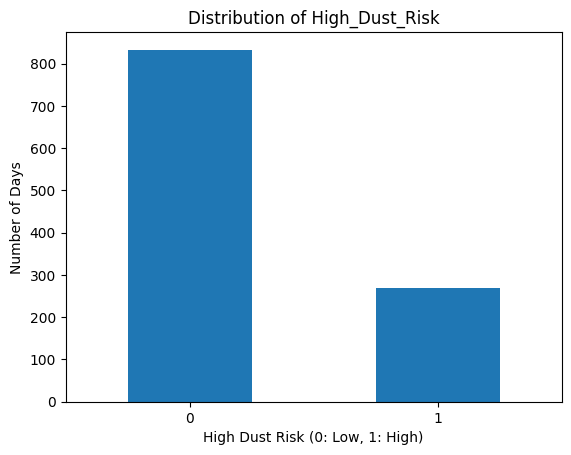

In [37]:
df['High_Dust_Risk'].value_counts().plot(kind='bar')
plt.title('Distribution of High_Dust_Risk')
plt.xlabel('High Dust Risk (0: Low, 1: High)')
plt.ylabel('Number of Days')
plt.xticks(rotation=0)
plt.show()

Building model using smote

In [38]:
!pip install -q imbalanced-learn xgboost

In [39]:
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline as IMBPipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier

In [40]:
target = 'High_Dust_Risk'
base_feats = [
    'WS10M','RH2M','CLOUD_AMT','TS','GWETTOP','u10','v10',
    'days_since_rain',
    'k_t_r7','WS10M_r7','RH2M_r7','CLOUD_AMT_r7','Dust_Index_r7',
    'WS10M_lag1','RH2M_lag1','Dust_Index_lag1',
    'WS10M_lag3','RH2M_lag3','Dust_Index_lag3',
    'sin_doy','cos_doy'
]
features = [c for c in base_feats if c in df.columns]

Split data

In [41]:
data = df.dropna(subset=features+[target]).copy()
X, y = data[features], data[target].astype(int)


split_idx = int(len(X)*0.8)
X_tr, y_tr = X.iloc[:split_idx], y.iloc[:split_idx]
X_te, y_te = X.iloc[split_idx:], y.iloc[split_idx:]

Logistic

In [42]:
logit_pipe = IMBPipeline(steps=[
    ('imp', SimpleImputer(strategy='median')),
    ('sc', StandardScaler()),
    ('sm', SMOTE(random_state=42, k_neighbors=5)),
    ('clf', LogisticRegression(max_iter=2000, class_weight='balanced', n_jobs=None))
])

RandomForest

In [43]:
rf_pipe = IMBPipeline(steps=[
    ('imp', SimpleImputer(strategy='median')),
    ('sm', SMOTE(random_state=42, k_neighbors=5)),
    ('clf', RandomForestClassifier(
        n_estimators=600, max_depth=None, min_samples_leaf=2,
        class_weight='balanced_subsample', random_state=42, n_jobs=-1))
])

In [44]:
logit_pipe.fit(X_tr, y_tr)
rf_pipe.fit(X_tr, y_tr)

Pipeline(steps=[('imp', SimpleImputer(strategy='median')),
                ('sm', SMOTE(random_state=42)),
                ('clf',
                 RandomForestClassifier(class_weight='balanced_subsample',
                                        min_samples_leaf=2, n_estimators=600,
                                        n_jobs=-1, random_state=42))])

In [45]:
from sklearn.metrics import precision_recall_curve, roc_auc_score, classification_report, confusion_matrix

In [46]:
def evaluate(model, name):
    proba = model.predict_proba(X_te)[:,1]
    auc = roc_auc_score(y_te, proba)

    p, r, thr = precision_recall_curve(y_te, proba)
    f1 = (2*p*r)/(p+r+1e-9)
    i = f1.argmax()
    best_thr = thr[i-1] if i>0 else 0.5

    y_hat = (proba >= best_thr).astype(int)
    print(f"\n{name} | ROC-AUC={auc:.3f} | BestThr={best_thr:.2f}")
    print(classification_report(y_te, y_hat, digits=3))
    print("Confusion Matrix:\n", confusion_matrix(y_te, y_hat))
    return best_thr, proba

thr_logit, p_logit = evaluate(logit_pipe, "Logistic+SMOTE")
thr_rf,    p_rf    = evaluate(rf_pipe,    "RF+SMOTE")


Logistic+SMOTE | ROC-AUC=0.847 | BestThr=0.67
              precision    recall  f1-score   support

           0      0.915     0.888     0.901       170
           1      0.661     0.725     0.692        51

    accuracy                          0.851       221
   macro avg      0.788     0.807     0.797       221
weighted avg      0.856     0.851     0.853       221

Confusion Matrix:
 [[151  19]
 [ 14  37]]

RF+SMOTE | ROC-AUC=0.913 | BestThr=0.62
              precision    recall  f1-score   support

           0      0.929     0.918     0.923       170
           1      0.736     0.765     0.750        51

    accuracy                          0.882       221
   macro avg      0.832     0.841     0.837       221
weighted avg      0.884     0.882     0.883       221

Confusion Matrix:
 [[156  14]
 [ 12  39]]


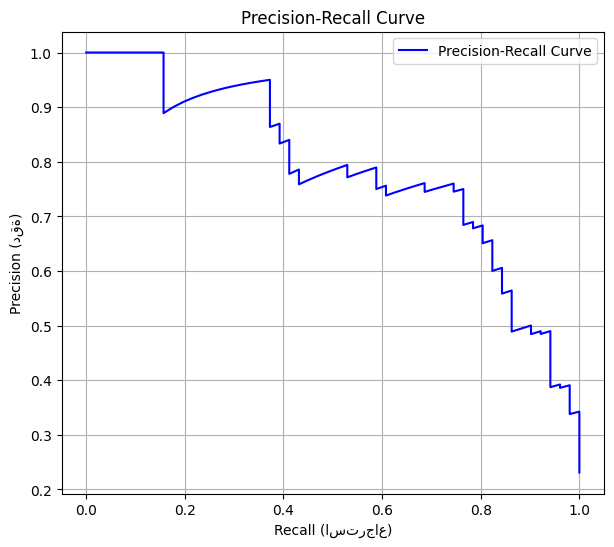

In [47]:
y_scores = rf_pipe.predict_proba(X_te)[:, 1]


precisions, recalls, thresholds = precision_recall_curve(y_te, y_scores)


plt.figure(figsize=(7,6))
plt.plot(recalls, precisions, label="Precision-Recall Curve", color="blue")
plt.xlabel("Recall (استرجاع)")
plt.ylabel("Precision (دقة)")
plt.title("Precision-Recall Curve")
plt.legend()
plt.grid(True)
plt.show()

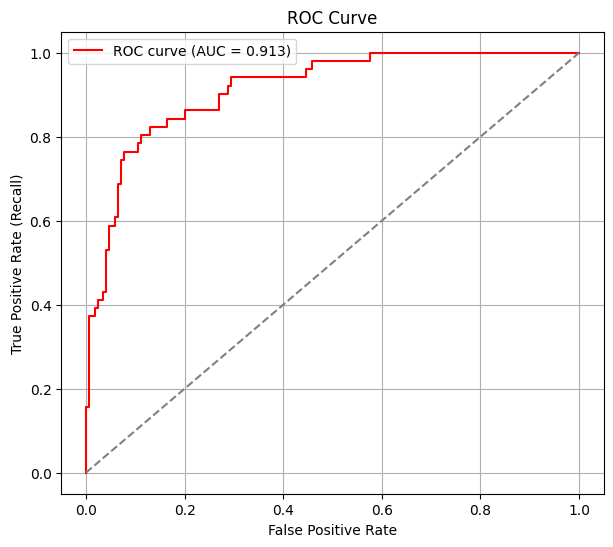

In [48]:
from sklearn.metrics import roc_curve, auc

fpr, tpr, _ = roc_curve(y_te, y_scores)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(7,6))
plt.plot(fpr, tpr, label=f"ROC curve (AUC = {roc_auc:.3f})", color="red")
plt.plot([0,1],[0,1],'--',color='gray')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate (Recall)")
plt.title("ROC Curve")
plt.legend()
plt.grid(True)
plt.show()

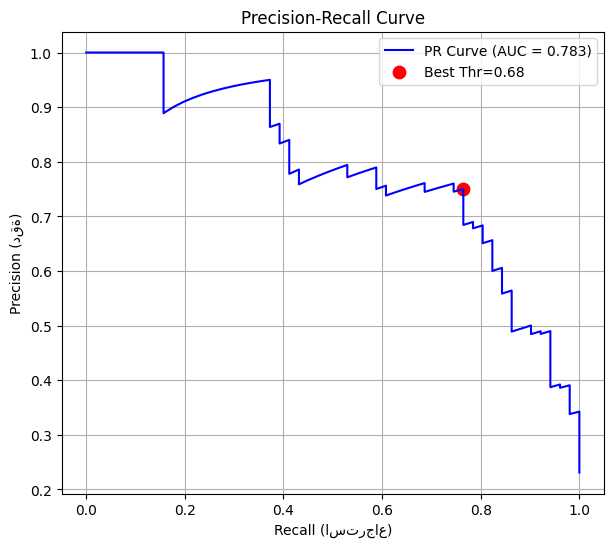

In [49]:
from sklearn.metrics import precision_recall_curve, auc

precisions, recalls, thresholds = precision_recall_curve(y_te, y_scores)


pr_auc = auc(recalls, precisions)

plt.figure(figsize=(7,6))
plt.plot(recalls, precisions, color="blue", label=f"PR Curve (AUC = {pr_auc:.3f})")
plt.xlabel("Recall (استرجاع)")
plt.ylabel("Precision (دقة)")
plt.title("Precision-Recall Curve")
plt.legend()
plt.grid(True)

best_thr = 0.68
best_idx = (np.abs(thresholds - best_thr)).argmin()
plt.scatter(recalls[best_idx], precisions[best_idx], color="red", s=80, label=f"Best Thr={best_thr}")
plt.legend()
plt.show()

Save the model

In [50]:
import joblib

# حفظ المودل
joblib.dump(rf_pipe, "random_forest_dust_model.pkl")

print("✅ تم حفظ المودل باسم random_forest_dust_model.pkl")

✅ تم حفظ المودل باسم random_forest_dust_model.pkl


improve the model and add more columns

In [197]:
'''
url = "https://air-quality-api.open-meteo.com/v1/air-quality"
params = {
    "latitude": 24.7136,
    "longitude": 46.6753,
    "start": "2022-01-01T00:00",
    "end": "2025-01-01T00:00",
    "hourly": "pm2_5,pm10"
}
r = requests.get(url, params=params).json()

df = pd.DataFrame({
    "time": r["hourly"]["time"],
    "pm25": r["hourly"]["pm2_5"],
    "pm10": r["hourly"]["pm10"]
})
df["time"] = pd.to_datetime(df["time"])
df.to_csv("openmeteo_pm_riyadh.csv", index=False)
print("✅ Saved openmeteo_pm_riyadh.csv")
'''

'\nurl = "https://air-quality-api.open-meteo.com/v1/air-quality"\nparams = {\n    "latitude": 24.7136,\n    "longitude": 46.6753,\n    "start": "2022-01-01T00:00",\n    "end": "2025-01-01T00:00",\n    "hourly": "pm2_5,pm10"\n}\nr = requests.get(url, params=params).json()\n\ndf = pd.DataFrame({\n    "time": r["hourly"]["time"],\n    "pm25": r["hourly"]["pm2_5"],\n    "pm10": r["hourly"]["pm10"]\n})\ndf["time"] = pd.to_datetime(df["time"])\ndf.to_csv("openmeteo_pm_riyadh.csv", index=False)\nprint("✅ Saved openmeteo_pm_riyadh.csv")\n'

In [198]:
'''
data_pm = pd.read_csv('openmeteo_pm_riyadh.csv')
data_pm
'''

"\ndata_pm = pd.read_csv('openmeteo_pm_riyadh.csv')\ndata_pm\n"

cheack for data

In [199]:
'''
data_pm["time"] = pd.to_datetime(data_pm["time"])

start_date = data_pm["time"].min()
end_date   = data_pm["time"].max()

print(" البيانات تبدأ من:", start_date)
print(" البيانات تنتهي عند:", end_date)
'''

'\ndata_pm["time"] = pd.to_datetime(data_pm["time"])\n\nstart_date = data_pm["time"].min()\nend_date   = data_pm["time"].max()\n\nprint(" البيانات تبدأ من:", start_date)\nprint(" البيانات تنتهي عند:", end_date)\n'

In [200]:
'''
data_pm["time"] = pd.to_datetime(data_pm["time"])

start_date = data_pm["time"].min()
end_date   = data_pm["time"].max()

duration = end_date - start_date
hours = duration.total_seconds() / 3600
days = duration.days

print(" البداية:", start_date)
print(" النهاية:", end_date)
print(" المدة الكاملة:", duration)
print(" عدد الأيام:", days + 1)
print(" عدد الساعات:", int(hours))
'''

'\ndata_pm["time"] = pd.to_datetime(data_pm["time"])\n\nstart_date = data_pm["time"].min()\nend_date   = data_pm["time"].max()\n\nduration = end_date - start_date\nhours = duration.total_seconds() / 3600\ndays = duration.days\n\nprint(" البداية:", start_date)\nprint(" النهاية:", end_date)\nprint(" المدة الكاملة:", duration)\nprint(" عدد الأيام:", days + 1)   \nprint(" عدد الساعات:", int(hours))\n'

In [201]:
'''
data_pm["time"] = pd.to_datetime(data_pm["time"])

data_pm["date"] = data_pm["time"].dt.date

daily_pm = data_pm.groupby("date")[["pm25", "pm10"]].mean().reset_index()


print(daily_pm.head())


daily_pm.to_csv("openmeteo_pm_riyadh_daily.csv", index=False)
print(" Saved to openmeteo_pm_riyadh_daily.csv")
'''

'\ndata_pm["time"] = pd.to_datetime(data_pm["time"])\n\ndata_pm["date"] = data_pm["time"].dt.date\n\ndaily_pm = data_pm.groupby("date")[["pm25", "pm10"]].mean().reset_index()\n\n\nprint(daily_pm.head())\n\n\ndaily_pm.to_csv("openmeteo_pm_riyadh_daily.csv", index=False)\nprint(" Saved to openmeteo_pm_riyadh_daily.csv")\n'

fouces in WD10M for the model

In [203]:
RISK_LO = 157
RISK_HI = 180


def in_risky_sector(wd, lo=RISK_LO, hi=RISK_HI):

    if pd.isna(wd):
        return np.nan
    wd = wd % 360
    return 1.0 if (lo <= wd <= hi) else 0.0


def add_wind_direction_features(df):


    df['WD10M_rad'] = np.deg2rad(df['WD10M'] % 360)
    df['WD10M_sin'] = np.sin(df['WD10M_rad'])
    df['WD10M_cos'] = np.cos(df['WD10M_rad'])


    df['wind_risk_flag']  = df['WD10M'].apply(in_risky_sector)
    df['wind_risk_speed'] = df['WS10M'] * df['wind_risk_flag']
    return df

In [204]:
df = add_wind_direction_features(df)

In [205]:
base_feats = [
    'WS10M','RH2M','CLOUD_AMT','TS','GWETTOP','u10','v10',
    'days_since_rain',
    'k_t_r7','WS10M_r7','RH2M_r7','CLOUD_AMT_r7','Dust_Index_r7',
    'WS10M_lag1','RH2M_lag1','Dust_Index_lag1',
    'WS10M_lag3','RH2M_lag3','Dust_Index_lag3',
    'sin_doy','cos_doy'
]


wind_feats = ['WD10M_sin','WD10M_cos','wind_risk_flag','wind_risk_speed']


features_baseline = [c for c in base_feats if c in df.columns]
features_wind     = [c for c in list(dict.fromkeys(base_feats + wind_feats)) if c in df.columns]

target = 'High_Dust_Risk'

In [210]:
from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import f1_score, average_precision_score
from sklearn.ensemble import RandomForestClassifier
from imblearn.pipeline import Pipeline
from imblearn.over_sampling import SMOTE
import numpy as np

def evaluate(features):
    data = df.dropna(subset=features+[target]).copy()
    X, y = data[features], data[target].astype(int)

    tscv = TimeSeriesSplit(n_splits=5)
    f1s, apxs = [], []

    for tr, te in tscv.split(X):
        Xtr, Xte = X.iloc[tr], X.iloc[te]
        ytr, yte = y.iloc[tr], y.iloc[te]

        pipe = Pipeline(steps=[
            ('smote', SMOTE(random_state=42)),
            ('clf', RandomForestClassifier(
                n_estimators=300,
                max_depth=None,
                min_samples_split=2,
                min_samples_leaf=1,
                max_features='sqrt',
                class_weight='balanced_subsample',
                random_state=42,
                n_jobs=-1
            ))
        ])

        pipe.fit(Xtr, ytr)
        ypred  = pipe.predict(Xte)
        yproba = pipe.predict_proba(Xte)[:,1]

        f1s.append(f1_score(yte, ypred))
        apxs.append(average_precision_score(yte, yproba))

    return np.mean(f1s), np.std(f1s), np.mean(apxs), np.std(apxs)

f1_b, f1b_sd, ap_b, apb_sd = evaluate(features_baseline)
f1_w, f1w_sd, ap_w, apw_sd = evaluate(features_wind)

print("Baseline  -> F1: %.3f ± %.3f | PR-AUC: %.3f ± %.3f" % (f1_b, f1b_sd, ap_b, apb_sd))
print("With Wind -> F1: %.3f ± %.3f | PR-AUC: %.3f ± %.3f" % (f1_w, f1w_sd, ap_w, apw_sd))

Baseline  -> F1: 0.782 ± 0.038 | PR-AUC: 0.804 ± 0.047
With Wind -> F1: 0.766 ± 0.039 | PR-AUC: 0.805 ± 0.050


Xgboost

In [211]:
! pip install xgboost

In [214]:
from xgboost import XGBClassifier
from imblearn.pipeline import Pipeline
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import f1_score, average_precision_score
import numpy as np

def evaluate_xgb(features):
    data = df.dropna(subset=features+[target]).copy()
    X, y = data[features], data[target].astype(int)

    tscv = TimeSeriesSplit(n_splits=5)
    f1s, apxs = [], []

    for tr, te in tscv.split(X):
        Xtr, Xte = X.iloc[tr], X.iloc[te]
        ytr, yte = y.iloc[tr], y.iloc[te]

        pipe = Pipeline(steps=[
            ('smote', SMOTE(random_state=42)),
            ('clf', XGBClassifier(
                n_estimators=500,
                max_depth=6,
                learning_rate=0.05,
                subsample=0.8,
                colsample_bytree=0.8,
                scale_pos_weight=(ytr.value_counts()[0]/ytr.value_counts()[1]),
                random_state=42,
                n_jobs=-1,
                eval_metric="logloss"
            ))
        ])

        pipe.fit(Xtr, ytr)
        ypred  = pipe.predict(Xte)
        yproba = pipe.predict_proba(Xte)[:,1]

        f1s.append(f1_score(yte, ypred))
        apxs.append(average_precision_score(yte, yproba))

    return np.mean(f1s), np.std(f1s), np.mean(apxs), np.std(apxs)

# baseline vs with wind
f1_b, f1b_sd, ap_b, apb_sd = evaluate_xgb(features_baseline)
f1_w, f1w_sd, ap_w, apw_sd = evaluate_xgb(features_wind)

print("XGBoost Baseline  -> F1: %.3f ± %.3f | PR-AUC: %.3f ± %.3f" % (f1_b, f1b_sd, ap_b, apb_sd))
print("XGBoost With Wind -> F1: %.3f ± %.3f | PR-AUC: %.3f ± %.3f" % (f1_w, f1w_sd, ap_w, apw_sd))

XGBoost Baseline  -> F1: 0.767 ± 0.025 | PR-AUC: 0.809 ± 0.067
XGBoost With Wind -> F1: 0.770 ± 0.013 | PR-AUC: 0.813 ± 0.065
